In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_cal_helper as cal
import binary_image_helper as binar
import lane_polynomial_helper as lane
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# 1- Get object points

In [2]:
#Get object points (same for all images)
nx=9
ny=6
obj=cal.object_points(nx,ny)

#Create the image points and object points list
img_points=[]
obj_points=[]

for fname in glob.glob('camera_cal/calibration*.jpg'):
    #Read image
    img=cv2.imread(fname)
    #Find image points
    ret, corners = cal.find_corners_chessbooard(img,nx,ny,0)
    #Add points to list
    if ret:
        img_points.append(corners)
        obj_points.append(obj)

# 2- Define functions

## 2.1- Functions 

## 2.2- Class line

In [3]:
import line_class as line

# 3- Create pipeline

In [4]:
def binary_image(image):
    '''Isolates the lines very well, but have problems to find them in dark images'''
    binary_S = binar.HLS_threshold(image, channel='S', thresh=(150, 255))
    R_channel=image[:,:,0]
    binary_R = np.zeros_like(R_channel)
    binary_R[R_channel > 210] = 1
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dir_binary= binar.dir_sobel(gray, sobel_kernel=9, thresh=(0.8, 1.2))
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S_channel=image_HLS[:,:,2]
    abs_binary_S=binar.abs_sobel(S_channel, orient='x', sobel_kernel=7, thresh=(50, 100))
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (binary_S == 1))] = 1
    return combined

def alt_binary_image(image):
    '''Finds the lines, but adding a lot of noise'''
    binary_S = binar.HLS_threshold(image, channel='S', thresh=(150, 255))
    R_channel=image[:,:,0]
    binary_R = np.zeros_like(R_channel)
    binary_R[R_channel > 210] = 1
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dir_binary= binar.dir_sobel(gray, sobel_kernel=9, thresh=(0.8, 1.2))
    x_binary=binar.abs_sobel(gray, orient='x', sobel_kernel=9, thresh=(30, 150))
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (binary_S == 1)) | ((x_binary == 1) & (dir_binary == 1))] = 1
    return combined

def check_curvature(polyfit_right, polyfit_left):
    wrong = False
    if (polyfit_right[0]*polyfit_left[0]) < 0:
        wrong = True
    return wrong

def check_distance(distance_top, distance_bottom):
    error_d = 1 #m
    wrong = False
    if distance_top < 0 or distance_bottom < 0 or np.abs(distance_top - distance_bottom) > error_d:
        wrong = True
    return wrong

def pipeline(image):
    #Undistort image
    undistorted = cal.cal_undistort(image, obj_points, img_points)
    #Create binary image
    binary = binary_image(undistorted)
    #Make perspective transform
    top_img = cal.pers_transform(binary, x_offlow, x_offhigh)
    #Split image vertically in 2
    midpoint = top_img.shape[1]//2
    left_top = top_img[:, :midpoint]
    right_top = top_img[:, midpoint:]
    #Update line parameters
    right_line.new_line(right_top)
    left_line.new_line(left_top)
    #Check if both lines exist
    if not left_line.exists:
        #Change binary image and try again
        binary_2 = alt_binary_image(undistorted)
        top_img_2 = cal.pers_transform(binary_2, x_offlow, x_offhigh)
        left_top = top_img_2[:, :midpoint]
        left_line.init_line(left_top)
        if not left_line.exists:
            # Use previous line
            left_line.retrieve_line(left_top)          
    if not right_line.exists:
        #Change binary image and try again
        binary_2 = alt_binary_image(undistorted)
        top_img_2 = cal.pers_transform(binary_2, x_offlow, x_offhigh)
        right_top = top_img_2[:, midpoint:]
        right_line.init_line(right_top)
        if not right_line.exists:
            # Use previous line
            right_line.retrieve_line(right_top)        
    ##Safety check on the two lines
    #Calculate lines distance
    midpoint_m = midpoint * xm_per_pix
    dist_top = (midpoint_m + right_line.dist[1] - left_line.dist[1])
    dist_bottom = (midpoint_m + right_line.dist[0] - left_line.dist[0])
    #Check lines 
    if check_curvature(right_line.avefit, left_line.avefit) or check_distance(dist_top, dist_bottom):
        #Reuse previous lines
        right_line.line_returned(right_top)
        left_line.line_returned(left_top)
    #Extract information
    left_fitx = left_line.poly
    right_fitx = right_line.poly + midpoint
    left_curverad = left_line.curverad
    right_curverad = right_line.curverad
    dist_center = (midpoint_m - left_line.dist[0] - right_line.dist[0])/2
    #Draw the lines and the data
    ploty = np.linspace(0, top_img.shape[0]-1, top_img.shape[0])
    result_image = lane.lanes_image(image, left_fitx, right_fitx, ploty, x_offlow, x_offhigh)
    lane.add_lane_par(result_image, left_curverad, right_curverad, dist_center)
    return result_image  

# 4- Initialize calculation

## 4.1 - Parameters

In [5]:
x_offlow=450
x_offhigh=75
# Number of sliding windows
nwindows = 9
# Width of the windows +/- margin
margin = 100
# Minimum number of pixels found to recenter window
minpix = 50
# Meters per pixel in x and y direction
ym_per_pix = 3/160
xm_per_pix = 3.7/520

# 5- Apply

## 5.1- Test on image

### Initialize line

In [6]:
right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

### Run code

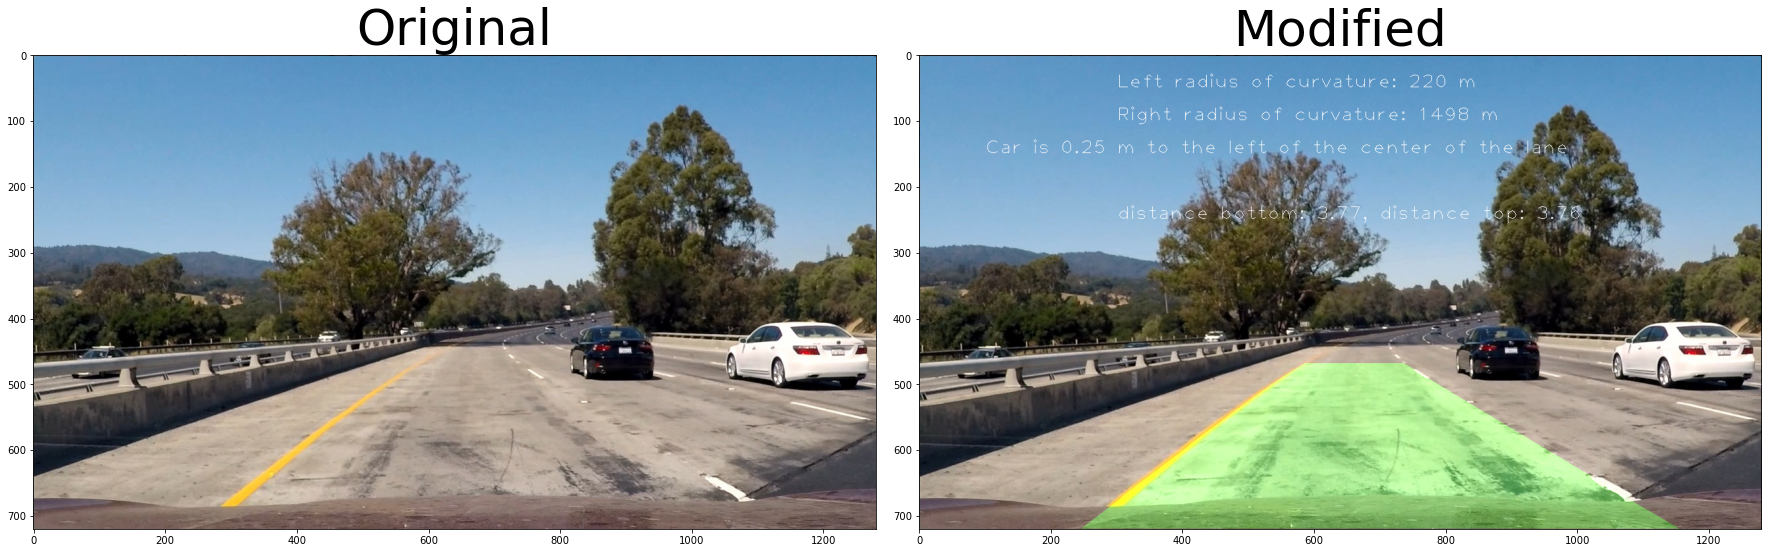

In [7]:
image = mpimg.imread('test_images/test1.jpg')
result = pipeline(image)
cal.compare_images(image, result, 0, None, 'RGB', 'RGB')

## 5.2- Video project

### Initialize line

In [42]:
right_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = line.Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

### Run on video

In [8]:
white_output = 'video_test_output_5.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_test_output_5.mp4.
Moviepy - Writing video video_test_output_5.mp4



Moviepy - Done !
Moviepy - video ready video_test_output_5.mp4
Wall time: 25min 56s


## 5.3- Challenge video

### Initialize line

In [14]:
right_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

### Run on video

In [15]:
white_output = 'video_challenge_test_output_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_challenge_test_output_3.mp4.
Moviepy - Writing video video_challenge_test_output_3.mp4



Moviepy - Done !
Moviepy - video ready video_challenge_test_output_3.mp4
Wall time: 26min 59s


In [72]:
left_line.fitlist

[]

## 5.4- Harder challenge video

### Initialize line

In [16]:
right_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)
left_line = Line(nwindows, margin, minpix, xm_per_pix, ym_per_pix)

In [17]:
white_output = 'video_hard_challenge_test_output_1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video video_hard_challenge_test_output_1.mp4.
Moviepy - Writing video video_hard_challenge_test_output_1.mp4



Moviepy - Done !
Moviepy - video ready video_hard_challenge_test_output_1.mp4
Wall time: 52min 1s
